In [1]:
import os
import shutil
import random
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix
import itertools


In [2]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
# Define paths
original_data_dir = "/content/drive/MyDrive/Apple"
split_data_dir = '/content/drive/MyDrive/AppleDiseases_Split'
train_data_dir = os.path.join(split_data_dir, 'train')
val_data_dir = os.path.join(split_data_dir, 'val')
test_data_dir = os.path.join(split_data_dir, 'test')


In [4]:
# Create directories if they don't exist
os.makedirs(train_data_dir, exist_ok=True)
os.makedirs(val_data_dir, exist_ok=True)
os.makedirs(test_data_dir, exist_ok=True)


In [ ]:
# # Function to split dataset
# def split_dataset(source, train, val, test, split_ratio=(0.8, 0.1, 0.1)):
#     classes = os.listdir(source)

#     for class_name in classes:
#         class_dir = os.path.join(source, class_name)
#         files = os.listdir(class_dir)
#         num_files = len(files)
#         num_train = int(num_files * split_ratio[0])
#         num_val = int(num_files * split_ratio[1])

#         train_files = files[:num_train]
#         val_files = files[num_train:num_train + num_val]
#         test_files = files[num_train + num_val:]

#         # Copy train files
#         for file in train_files:
#             src_file = os.path.join(class_dir, file)
#             dest_file = os.path.join(train, class_name, file)
#             os.makedirs(os.path.join(train, class_name), exist_ok=True)
#             if os.path.isfile(src_file):
#                 shutil.copy(src_file, dest_file)

#         # Copy validation files
#         for file in val_files:
#             src_file = os.path.join(class_dir, file)
#             dest_file = os.path.join(val, class_name, file)
#             os.makedirs(os.path.join(val, class_name), exist_ok=True)
#             if os.path.isfile(src_file):
#                 shutil.copy(src_file, dest_file)

#         # Copy test files
#         for file in test_files:
#             src_file = os.path.join(class_dir, file)
#             dest_file = os.path.join(test, class_name, file)
#             os.makedirs(os.path.join(test, class_name), exist_ok=True)
#             if os.path.isfile(src_file):
#                 shutil.copy(src_file, dest_file)

# # Split dataset
# split_dataset(original_data_dir, train_data_dir, val_data_dir, test_data_dir)


In [5]:

# Image parameters
img_size = 256
batch_size = 32
shuffle_size = 1000
img_shape = (img_size, img_size, 3)


In [6]:
# Data Augmentation
datagen = ImageDataGenerator(
    horizontal_flip=True,
    zoom_range=0.1,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    preprocessing_function=tf.keras.applications.resnet.preprocess_input
)


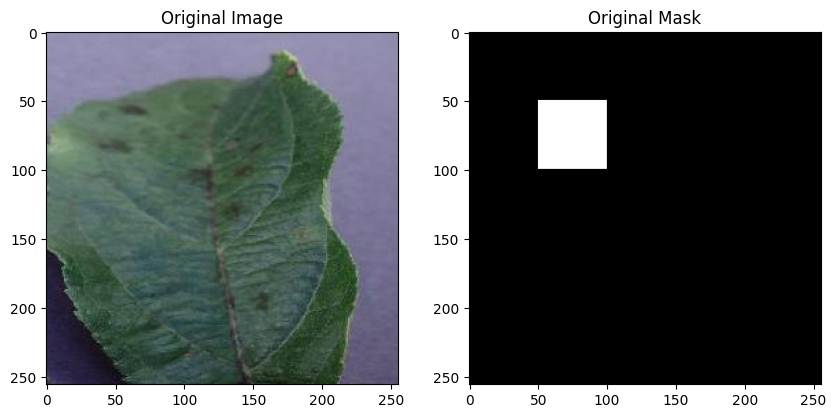

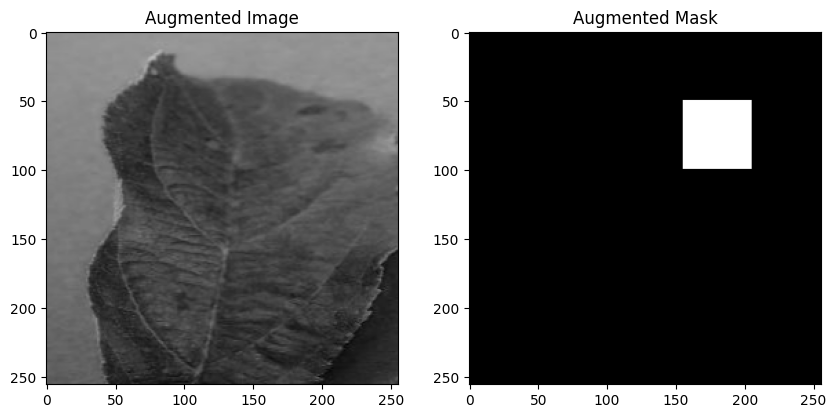

In [7]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import preprocess_input
import matplotlib.pyplot as plt

# Define a custom data generator for segmentation
class SegmentationDataGenerator(ImageDataGenerator):
    def __init__(self, segmentation_args=None, **kwargs):
        super().__init__(**kwargs)
        self.segmentation_args = segmentation_args

    def apply_segmentation_augmentation(self, image, mask):
        # Apply segmentation-specific augmentation here
        if self.segmentation_args.get('horizontal_flip', False):
            if np.random.random() < 0.5:
                image = np.fliplr(image)
                mask = np.fliplr(mask)

        if self.segmentation_args.get('rotation_range', 0) > 0:
            rotation_range = self.segmentation_args.get('rotation_range')
            theta = np.random.uniform(-rotation_range, rotation_range)
            image = tf.keras.preprocessing.image.random_rotation(image, theta)
            mask = tf.keras.preprocessing.image.random_rotation(mask, theta)

        if self.segmentation_args.get('width_shift_range', 0) > 0 or self.segmentation_args.get('height_shift_range', 0) > 0:
            w_shift = self.segmentation_args.get('width_shift_range')
            h_shift = self.segmentation_args.get('height_shift_range')
            image = tf.keras.preprocessing.image.random_shift(image, w_shift, h_shift)
            mask = tf.keras.preprocessing.image.random_shift(mask, w_shift, h_shift)

        return image, mask

    def flow(self, x, y=None, batch_size=32, shuffle=True):
        return SegmentationIterator(
            x, y, self,
            batch_size=batch_size,
            shuffle=shuffle
        )

from tensorflow.keras.utils import Sequence

# Define a custom iterator for segmentation
class SegmentationIterator(Sequence):
    def __init__(self, x_set, y_set, image_data_generator, batch_size=32, shuffle=True):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.image_data_generator = image_data_generator
        self.indexes = np.arange(len(self.x))
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __len__(self):
        return len(self.x) // self.batch_size

    def __getitem__(self, idx):
        batch_indexes = self.indexes[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_x = [self.x[i] for i in batch_indexes]
        batch_y = [self.y[i] for i in batch_indexes]
        return self.__data_generation(batch_x, batch_y)

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __data_generation(self, batch_x, batch_y):
        batch_images, batch_masks = [], []
        for i in range(len(batch_x)):
            image, mask = batch_x[i], batch_y[i]
            image, mask = self.image_data_generator.apply_segmentation_augmentation(image, mask)
            batch_images.append(image)
            batch_masks.append(mask)
        return np.array(batch_images), np.array(batch_masks)

# Define segmentation-specific augmentation arguments
segmentation_args = {
    'horizontal_flip': True,
    'rotation_range': 10,
    'width_shift_range': 0.1,
    'height_shift_range': 0.1
}

# Load an example image from your dataset
image_path = '/content/drive/MyDrive/Apple/Apple Apple scab/Apple_Apple_scab1.jpg'  # Replace with your actual image path
image = tf.keras.preprocessing.image.load_img(image_path)
image = tf.keras.preprocessing.image.img_to_array(image)

# Create a pseudo-mask for demonstration purposes
mask = np.zeros((image.shape[0], image.shape[1], 1), dtype=np.uint8)
mask[50:100, 50:100] = 1  # This is just an example mask

# Create an instance of the SegmentationDataGenerator
datagen = SegmentationDataGenerator(
    horizontal_flip=True,
    zoom_range=0.1,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    preprocessing_function=preprocess_input,
    segmentation_args=segmentation_args
)

# Display original image and mask
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image.astype(np.uint8))
plt.title('Original Image')
plt.subplot(1, 2, 2)
plt.imshow(mask[:, :, 0], cmap='gray')
plt.title('Original Mask')
plt.show()

# Generate augmented samples
augmented_images, augmented_masks = datagen.flow(
    np.expand_dims(image, axis=0),
    np.expand_dims(mask, axis=0),
    batch_size=1
).__getitem__(0)

# Display augmented image and mask
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(augmented_images[0].astype(np.uint8))
plt.title('Augmented Image')
plt.subplot(1, 2, 2)
plt.imshow(augmented_masks[0][:, :, 0], cmap='gray')
plt.title('Augmented Mask')
plt.show()


In [8]:
# Generators
train_generator = datagen.flow_from_directory(
    directory=train_data_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    shuffle=True
)

val_generator = datagen.flow_from_directory(
    directory=val_data_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    shuffle=False
)

test_generator = datagen.flow_from_directory(
    directory=test_data_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    shuffle=False
)


Found 8004 images belonging to 2 classes.
Found 999 images belonging to 2 classes.
Found 1003 images belonging to 2 classes.


In [9]:
# Define custom metrics
def recall(y_true, y_pred):
    true_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_true * y_pred, 0, 1)))
    possible_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_true, 0, 1)))
    recall_m = true_positives / (possible_positives + tf.keras.backend.epsilon())
    return recall_m

def precision(y_true, y_pred):
    true_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_true * y_pred, 0, 1)))
    predicted_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_pred, 0, 1)))
    precision_m = true_positives / (predicted_positives + tf.keras.backend.epsilon())
    return precision_m

def f1(y_true, y_pred):
    precision_m = precision(y_true, y_pred)
    recall_m = recall(y_true, y_pred)
    return 2 * ((precision_m * recall_m) / (precision_m + recall_m + tf.keras.backend.epsilon()))


In [10]:
# Load pre-trained ResNet50 model
resnet50 = tf.keras.applications.ResNet50(include_top=False, weights="imagenet", input_shape=img_shape)
resnet50.trainable = False


94765736/94765736 [==============================] - 5s 0us/step


In [11]:
# Build the model on top of ResNet50
x = resnet50.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dense(1024, activation='relu')(x)
x = Dense(512, activation='relu')(x)
predictions = Dense(2, activation="softmax")(x)
model = Model(inputs=resnet50.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.005), # Adjust learning rate
              loss='categorical_crossentropy',
              metrics=['acc', f1, precision, recall])

In [12]:
# Callbacks
checkpoint = ModelCheckpoint("resnet50_v1.h5",
                             monitor='val_acc',
                             verbose=1,
                             save_best_only=False,
                             save_weights_only=False,
                             mode='auto',
                             save_freq='epoch')

early = EarlyStopping(monitor='val_acc',
                      min_delta=0,
                      patience=10,
                      verbose=1,
                      mode='auto')


In [ ]:
# Training the model
history = model.fit(train_generator,
                    epochs=10,
                    validation_data=val_generator,
                    callbacks=[checkpoint, early])


Epoch 1/10
 80/251 [========>.....................] - ETA: 1:14:50 - loss: 2.0189 - acc: 0.8527 - f1: 0.8527 - precision: 0.8527 - recall: 0.8527

NameError: name 'history' is not defined

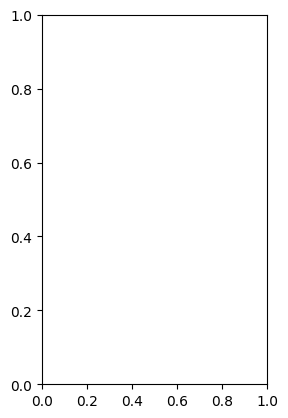

In [13]:

plt.subplot(1, 2, 2)
plt.plot(history.history['acc'], label='Training Accuracy')
plt.plot(history.history['val_acc'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:

# Evaluate the model on test data
test_loss, test_accuracy, test_f1, test_precision, test_recall = model.evaluate(test_generator)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)
print("Test F1 Score:", test_f1)
print("Test Precision:", test_precision)
print("Test Recall:", test_recall)

32/32 [==============================] - 332s 10s/step - loss: 0.0231 - acc: 0.9930 - f1: 0.9932 - precision: 0.9932 - recall: 0.9932
Test Loss: 0.023100178688764572
Test Accuracy: 0.9930209517478943
Test F1 Score: 0.9931640625
Test Precision: 0.9931640625
Test Recall: 0.9931640625


In [ ]:

# Generate predictions
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes

32/32 [==============================] - 328s 10s/step


In [ ]:

# Plot confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


Confusion matrix, without normalization


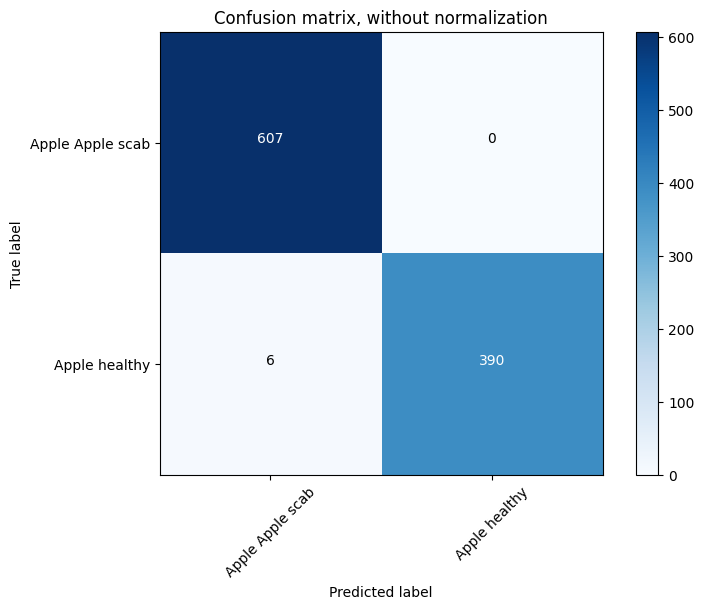

In [ ]:
# Compute confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# Plot non-normalized confusion matrix
plt.figure(figsize=(8, 6))
plot_confusion_matrix(conf_matrix, classes=test_generator.class_indices.keys(), title='Confusion matrix, without normalization')


In [ ]:
# Save the model in SavedModel format
saved_model_path = '/content/drive/MyDrive/saved_model'
tf.saved_model.save(model, saved_model_path)


In [ ]:

# Convert the SavedModel to TensorFlow Lite format
converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_path)
tflite_model = converter.convert()

In [ ]:
# Save the TensorFlow Lite model to a file
tflite_model_path = '/content/drive/MyDrive/AppleDiseaseModel1.tflite'
with open(tflite_model_path, 'wb') as f:
    f.write(tflite_model)

In [ ]:
# Save the model in HDF5 format
h5_model_path = '/content/drive/MyDrive/AppleDiseaseModel1.h5'
model.save(h5_model_path)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
